In [19]:
import networkx as nx
import time
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
# from networkx.algorithms import community
import community as louvain
import matplotlib.cm as cm
import matplotlib.colors as mpcol
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon
from community import community_louvain

%matplotlib inline

In [20]:
import pandas as pd
import osmnx as ox
import networkx as nx
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities
from IPython.display import Image
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'1.1.1'

In [21]:
def undirected_network(G):
    G_simple = nx.Graph()
    for i,j,data in G.edges(data=True):
        w = data['weight'] if 'weight' in data else 1.0
        if G_simple.has_edge(i,j):
            G_simple[i][j]['weight'] += w
        else:
            G_simple.add_edge(i,j,weight=w)
    return G_simple

In [22]:
def find_communities(G):
    start_time = time.time()
    partition = community_louvain.best_partition(G)
    part_dict = {}
    values = []
    for node in G.nodes():
        values.append(partition.get(node))
        part_dict.update({node:partition.get(node)})
    communities_louvain1 = max(values)+1
    end_time = time.time()
    mod_louvain = community_louvain.modularity(partition,G)
    print('Communities found using the Louvain algorithm: {} \nModularity: {} \nTime for finding the communities: {} s'.format(communities_louvain1, mod_louvain,round((end_time-start_time),3)))
    return part_dict

In [23]:
def plot_communities(city_sw):
    
    #List of color
    Color_barragan = ['#E1CF3F','#F47757','#FD4581','#97577C','#BDA7A9','#E1CF3F','#F47757','#FD4581',
                 '#e44623','#e45a6a','#c9d3e6','#7d513d',
                 '#e65949','#d6b240','#382a29','#d8d4c9',
                 '#e4cc34','#ccb42c','#bc8ca4','#3c84c4',
                 '#dd4d3d','#52172f','#63494a','#e2d5d3',
                 '#f7abcc','#e085a1','#943d39','#2d1d19']
    #Create the color map
    Barragan = mpcol.ListedColormap(Color_barragan, name='Barragan')
    G_drive = ox.project_graph(city_sw)
    G_simple = undirected_network(G_drive)
    part_dict = find_communities(G_simple)
    nx.set_node_attributes(G_drive, part_dict, 'community')
    communities = [(G_drive.nodes()[i]['community']) for i in G_drive.nodes()]
    com = [x[1] for x in G_drive.nodes(data='community')]
    norm = mpcol.Normalize(vmin=min(com), vmax=max(com), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=Barragan)
    nc=[mapper.to_rgba(x) for x in com]
    save = True

    fig, ax = ox.plot_graph(G_drive, bgcolor='black', node_color=nc, node_size=8.5, node_zorder=3, node_alpha=1, 
                        edge_linewidth=0.25, edge_color='white',edge_alpha=1,close=True, show=True,
                         save=save)

In [24]:
# get street networks by location name
def get_street_network(location):
    G = ox.graph_from_place(location)
    ox.plot_graph(G)

#get street network from polygon and save to shp
def get_street_network_shp(location, location_name):
    polygon = location.iloc[0]['geometry']
    G = ox.graph_from_polygon(polygon)
    ox.save_graph_shapefile(G, filepath=location_name)
    ox.plot_graph(G)
    return G  

# get street networks by bbox
def get_street_network_bbox(north,south,east,west):
    G = ox.graph_from_bbox(north,south,east,west)
#     G_projected = ox.project_graph(G)
#     ox.plot_graph(G_projected)

#get network metrics
def get_network_metrics(city_sw, location_name):
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(city_sw)
    gdf_nodes.to_csv(f'drone-network-metrics/{location_name}-nodes.csv')
    gdf_edges.to_csv(f'drone-network-metrics/{location_name}-edges.csv')

    closeness_centrality = nx.closeness_centrality(city_sw)
    closeness_table = pd.DataFrame(list(closeness_centrality.items()))
    closeness_table.to_csv(f'drone-network-metrics/{location_name}-closeness.csv')
    
    betweeness_centrality = nx.betweenness_centrality(ox.get_digraph(city_sw), weight='length')
    betweeness_table = pd.DataFrame(list(betweeness_centrality.items()))
    betweeness_table.to_csv(f'drone-network-metrics/{location_name}-betweeness.csv')

#     page_rank = nx.pagerank(city_sw, alpha=0.8)
#     page_rank_table = pd.DataFrame(list(page_rank.items()))
#     page_rank.to_csv(f'network-metrics/{location_name}-page_rank.csv')

    return gdf_nodes, gdf_edges, closeness_table, betweeness_table

In [30]:
# configure the inline image display
img_folder = "images"
extension = "png"
size =600

# specify that we're retrieving building footprint geometries
tags = {"building": True}

# get buildings only from point
def get_bldgs(place,point,dist=1800):
    fp = f"./{img_folder}/{place}-bldgs.{extension}"
    G = ox.geometries_from_point(point, tags, dist=dist)
    ox.plot_footprints(G, dpi=600, filepath=fp, save=True)


# visualize streets + building footprints
def get_street_bldg(
    place,
    point,
    network_type="drive",
    dpi=600,
    dist=1800,
    default_width=1,
    street_widths=None,
):
    fp = f"./{img_folder}/{place}.{extension}"
    gdf = ox.geometries_from_point(point, tags, dist=dist)
    fig, ax = ox.plot_figure_ground(
        point=point,
        dist=dist,
        network_type=network_type,
        default_width=default_width,
        street_widths=street_widths,
        save=False,
        show=False,
        close=True,
    )
    ox.plot_footprints(
        gdf, ax=ax, filepath=fp, dpi=dpi, save=True)

C:\Users\rache\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# get street networks by point
def get_street_networks_pt(point, location_name,dist=1800):
    dist=dist
    G = ox.graph_from_point(point, dist=dist)
    ox.plot_graph(G)
    ox.save_graph_shapefile(G, filepath=location_name)
    return G

# Street Networks

## Lupang Arienda

In [31]:
la_lnglat = (14.541076982278684, 121.11099781402845)
dist = 1800  # meters

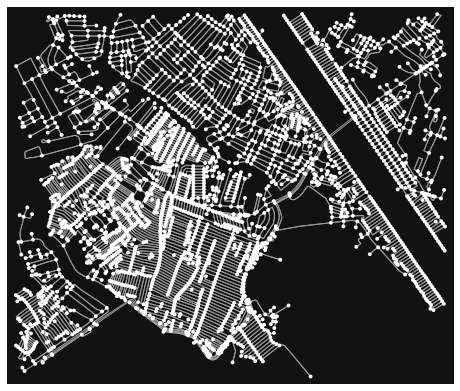

C:\Users\rache\anaconda3\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


In [32]:
lupang_arienda_sw = get_street_networks_pt(la_lnglat, 'lupang-arienda')
lupang_arienda_sw

C:\Users\rache\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Communities found using the Louvain algorithm: 46 
Modularity: 0.941231167314011 
Time for finding the communities: 1.899 s


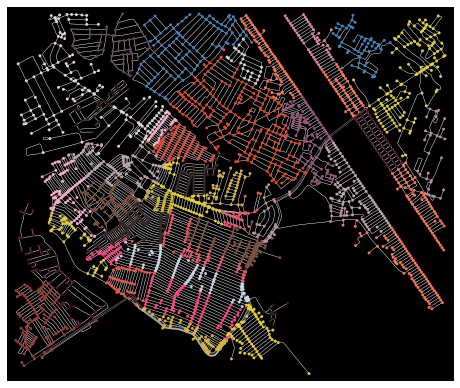

In [33]:
plot_communities(lupang_arienda_sw)

In [34]:
get_street_bldg('lupang_arienda',la_lnglat)

C:\Users\rache\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 432x288 with 0 Axes>

C:\Users\rache\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


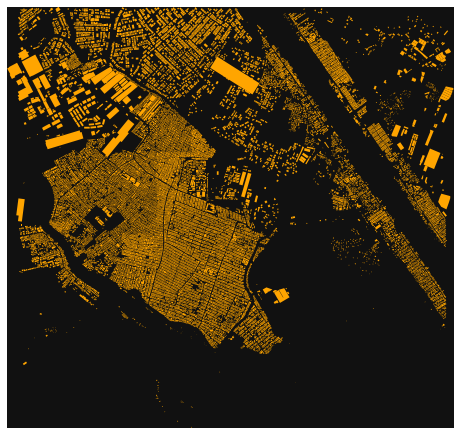

In [35]:
get_bldgs('lupang_arienda',la_lnglat)

## Dumaguete Foundation University

In [27]:
du_lnglat = (9.30527380196898, 123.29987231881549)
dist = 2500  # meters

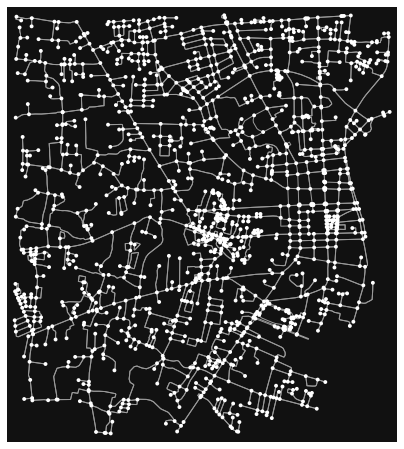

C:\Users\rache\anaconda3\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


In [15]:
du_foundation_sw = get_street_networks_pt(du_lnglat, 'dumaguete-foundation')
du_foundation_sw

Communities found using the Louvain algorithm: 34 
Modularity: 0.9166361049341105 
Time for finding the communities: 0.956 s


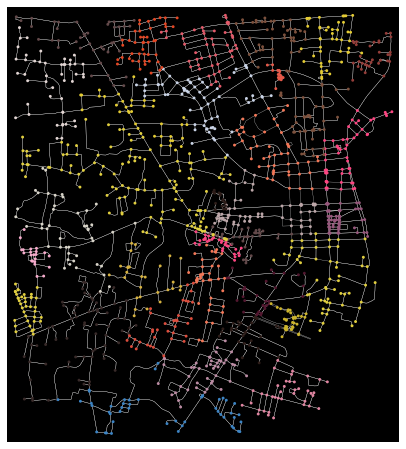

In [16]:
plot_communities(du_foundation_sw)

In [36]:
get_street_bldg('dumaguete-foundation',du_lnglat, dist=2500)

C:\Users\rache\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 432x288 with 0 Axes>

C:\Users\rache\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


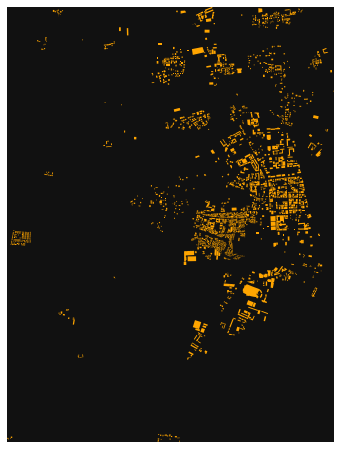

In [29]:
get_bldgs('dumaguete-foundation',du_lnglat,dist=2500)